In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [3]:
df_raw = pd.read_csv("2023-10-22_12 02 59_weather_log.csv")

# 01 Explore data

In [ ]:
df_raw.head()

In [ ]:
df_raw.info()

In [ ]:
df_raw.corr()

In [ ]:
current = df_raw['current'].to_numpy()
voltage = df_raw['voltage'].to_numpy()
power = df_raw['power'].to_numpy()
uvi = df_raw['uvi'].to_numpy()

In [ ]:
uvi.min()

In [ ]:
current.max()

In [ ]:
voltage.max()

In [ ]:
power.max()

In [ ]:
unique, counts = np.unique(current, return_counts=True)

print(dict(zip(unique, counts)))

In [ ]:
df_raw.info()

# 02 Pre-process data

In [5]:
df_processed = df_raw.copy()

### Set current to 0 for absolute values of 1.25

In [6]:
df_processed.loc[df_processed.current <= 1.25, 'current'] = 0

In [ ]:
unique, counts = np.unique(df_processed.current, return_counts=True)

print(dict(zip(unique, counts)))

In [7]:
df_processed.loc[df_processed.voltage < 0, 'voltage'] = 0
df_processed.loc[df_processed.current == 0, 'voltage'] = 0
df_processed.loc[df_processed.current == 0, 'power'] = 0

In [8]:
df_processed['is_day'] = df_processed.apply(lambda row: 1 if row['sunrise'] < row['dt'] and row['sunset'] > row['dt'] else 0, axis=1)

In [9]:
df_processed.drop(columns=['sunset', 'sunrise', 'visibility'], inplace=True)

In [ ]:
df_processed.corr()

In [ ]:
df_processed[(df_processed.is_day == 0) & (df_processed.power > 0)]

In [10]:
df_processed.loc[df_processed.is_day == 0, ['current','voltage','power']] = 0

In [11]:
df_processed[(df_processed.is_day == 0) & (df_processed.power > 0)]

,dt,clouds,uvi,temp,wind_speed,wind_deg,wind_gust,feels_like,pressure,dew_point,humidity,current,voltage,power,is_day


In [ ]:
df_processed['dt'] = df_processed['dt'].map(lambda timestamp: datetime.fromtimestamp(timestamp))

In [ ]:
df_processed['dt'] = df_processed['dt'].dt.time

In [48]:
df_processed['dt']

0       1696947124
1       1696947725
2       1696948325
3       1696948926
4       1696949527
           ...    
1518    1697966512
1519    1697967113
1520    1697967713
1521    1697968314
1522    1697968915
Name: dt, Length: 1523, dtype: int64

In [ ]:
df_processed['dt'] = df_processed['dt'].map(lambda time: (time.hour * 60 + time.minute)*60+time.second)

In [ ]:
df_processed.corr()

# Exploration

In [ ]:
sns.pairplot(df_processed)

In [12]:
df_reduced = df_processed.copy()

In [13]:
df_reduced.drop(columns=['wind_speed', 'wind_deg', 'wind_gust', 'feels_like', 'dew_point', 'humidity'], inplace=True)

In [ ]:
df_reduced.corr()

In [ ]:
sns.pairplot(df_reduced)

# Setup Model

## Multivariate Polynomial Regression

In [14]:
degree = 2

### All data

In [14]:
X_complete = df_processed.drop(columns=['power', 'current', 'voltage'], axis=1)
y_complete = df_processed['power']

In [15]:
X_train_complete, X_test_complete, y_train_complete, y_test_complete = train_test_split(X_complete, y_complete, test_size=0.3, random_state=101)

### Reduced data

In [16]:
X_reduced = df_reduced.drop(columns=['power', 'current', 'voltage'], axis=1)
y_reduced = df_reduced['power']

##### All RMSE values according to random_state=101

In [17]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, test_size=0.3, random_state=101)

### Support Vector Regression

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
StdS_X = StandardScaler()
StdS_y = StandardScaler()

#### Complete Data
- Complete Data RMSE: 1381.2640889219967

In [60]:
y_train_complete_shaped = y_train_complete.to_numpy().reshape(-1,1)
X_train_complete_scaled = StdS_X.fit_transform(X_train_complete)
y_train_complete_scaled = StdS_y.fit_transform(y_train_complete_shaped)
regressor_complete = SVR(kernel='rbf')
regressor_complete.fit(X_train_complete_scaled,y_train_complete_scaled.ravel())
pred_complete = StdS_y.inverse_transform(regressor_complete.predict(StdS_X.transform(X_test_complete)).reshape(-1,1))
RMSE_complete = mean_squared_error(y_test_complete,pred_complete,squared=False)
print(RMSE_complete)

1381.2640889219967


##### Hyperparameter optimization with gridsearch
- RMSE: 1326.0161044678691

First Grid search with:
grid = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' : [1,5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')}
BEST: SVR(C=10, coef0=10, gamma='auto', kernel='poly')
RMSE: 1326.01

Second Grid search with:
grid = {'kernel' : ('poly', 'rbf'),'C' : [10,15,20],'degree' : [3],'coef0' : [8,10,12],'gamma' : ('auto','scale')}
BEST: SVR(C=10, coef0=12, gamma='scale', kernel='poly')
RMSE: 1327.4266682134587

Third Grid search with:
grid = {'kernel' : ('poly', 'rbf'),'C' : [9,10,11],'degree' : [2,3,4],'coef0' : [11,12,13],'gamma' : ('auto','scale')}

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
param_grid = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' : [1,5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')}
regressor = SVR()

In [21]:
grids = GridSearchCV(regressor, param_grid, n_jobs = -1, verbose = 2)

In [23]:
y_train_complete_shaped = y_train_complete.to_numpy().reshape(-1,1)
X_train_complete_scaled = StdS_X.fit_transform(X_train_complete)
y_train_complete_scaled = StdS_y.fit_transform(y_train_complete_shaped)

In [24]:
grids.fit(X_train_complete_scaled,y_train_complete_scaled.ravel())

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[CV] END .C=1, coef0=0.01, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .C=1, coef0=0.01, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.1s
[CV] END .C=1, coef0=0.01, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .C=1, coef0=0.01, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..C=1, coef0=0.01, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, degree=3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ..C=1, coef0=0.01, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.1s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.1s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.1s
[CV] END ..C=1, coef0=0.01, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.

GridSearchCV(estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 5, 10], 'coef0': [0.01, 10, 0.5],
                         'degree': [3, 8], 'gamma': ('auto', 'scale'),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             verbose=2)

In [37]:
results_df = pd.read_feather('gridsearch_results.feather')

In [53]:
results_df.sort_values(by='rank_test_score').iloc[0]

mean_fit_time                                                 5.817711
std_fit_time                                                  1.061846
mean_score_time                                               0.002849
std_score_time                                                0.000045
param_C                                                             10
param_coef0                                                         10
param_degree                                                         3
param_gamma                                                       auto
param_kernel                                                      poly
params               {'C': 10, 'coef0': 10, 'degree': 3, 'gamma': '...
split0_test_score                                             0.785462
split1_test_score                                             0.764952
split2_test_score                                             0.837056
split3_test_score                                             0.771942
split4

In [59]:
y_train_complete_shaped = y_train_complete.to_numpy().reshape(-1,1)
X_train_complete_scaled = StdS_X.fit_transform(X_train_complete)
y_train_complete_scaled = StdS_y.fit_transform(y_train_complete_shaped)
regressor_complete = SVR(C=10, coef0=10, gamma='auto', kernel='poly', degree=3)
regressor_complete.fit(X_train_complete_scaled,y_train_complete_scaled.ravel())
pred_complete = StdS_y.inverse_transform(regressor_complete.predict(StdS_X.transform(X_test_complete)).reshape(-1,1))
RMSE_complete = mean_squared_error(y_test_complete,pred_complete,squared=False)
print(RMSE_complete)

1326.0161044678691


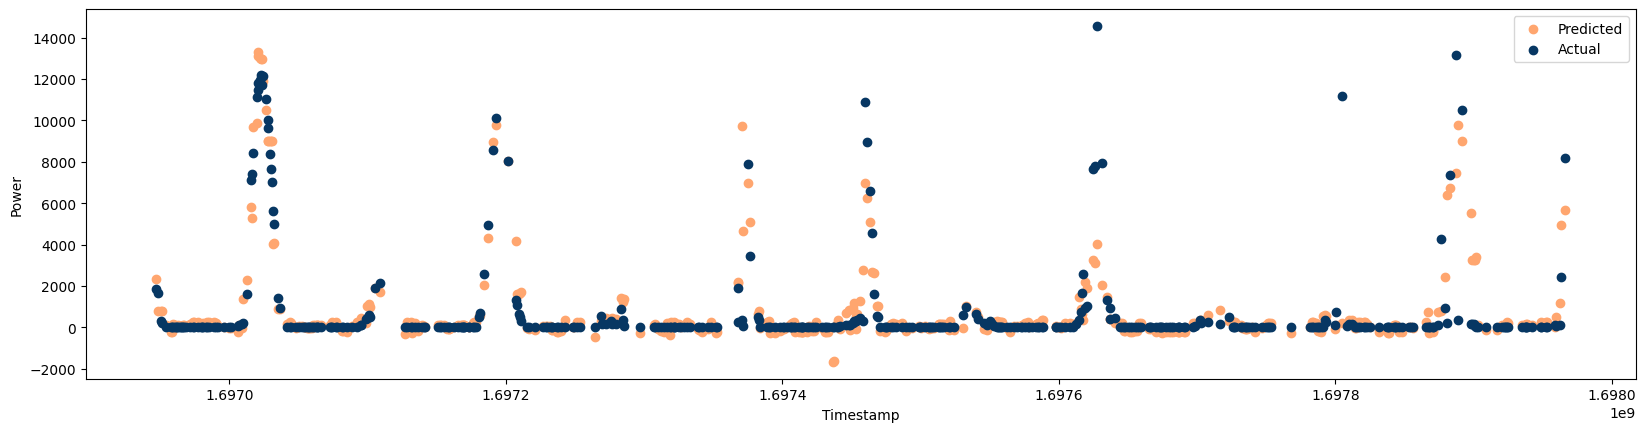

In [21]:
fig, ax = plt.subplots()

ax.scatter(X_test_complete['dt'], pred_complete, color='#ffa66f', label="Predicted")
ax.scatter(X_test_complete['dt'], y_test_complete, color='#073763', label="Actual")
legend = ax.legend(loc='upper right')
# ax.bar(hours, pred_complete)
fig.set_figwidth(20)
# plt.xticks(hours)
plt.ylabel("Power")
plt.xlabel("Timestamp")
plt.show()

#### Reduced Data
- Reduced Data RMSE: 1459.8550018116057

In [62]:
y_train_reduced_shaped = y_train_reduced.to_numpy().reshape(-1,1)
X_train_reduced_scaled = StdS_X.fit_transform(X_train_reduced)
y_train_reduced_scaled = StdS_y.fit_transform(y_train_reduced_shaped)
regressor_reduced = SVR(kernel='rbf')
regressor_reduced.fit(X_train_reduced_scaled,y_train_reduced_scaled.ravel())
pred_reduced = StdS_y.inverse_transform(regressor_reduced.predict(StdS_X.transform(X_test_reduced)).reshape(-1,1))
RMSE_reduced = mean_squared_error(y_test_reduced,pred_reduced,squared=False)
print(RMSE_reduced)

1459.8550018116057


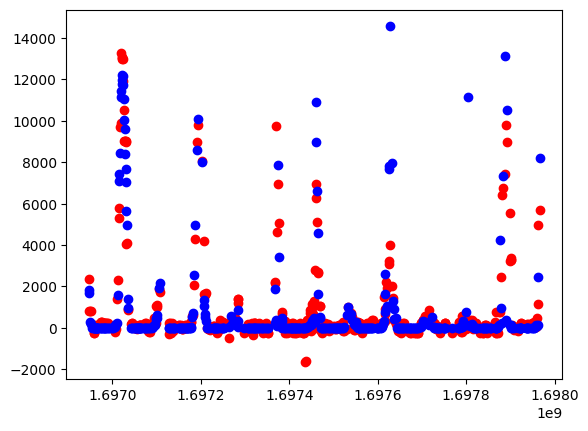

In [63]:
plt.scatter(x=X_test_reduced['dt'], y=pred_complete, color='red')
plt.scatter(x=X_test_reduced['dt'], y=y_test_complete, color='blue')
plt.show()

## Model Evaluation

### Linear Regression all data

- RMSE: 1736.311531009354

In [75]:
y_train_complete_shaped = y_train_complete.to_numpy().reshape(-1,1)
X_train_complete_scaled = StdS_X.fit_transform(X_train_complete)
y_train_complete_scaled = StdS_y.fit_transform(y_train_complete_shaped)
linear_model_complete = LinearRegression()
linear_model_complete.fit(X_train_complete_scaled,y_train_complete_scaled)

LinearRegression()

In [76]:
y_pred_linear_complete = StdS_y.inverse_transform(linear_model_complete.predict(StdS_X.transform(X_test_complete)).reshape(-1,1))

In [77]:
mean_squared_error(y_test_complete, y_pred_linear_complete, squared=False)

1736.311531009354

### Linear Regression reduced data

- RMSE: 1764.335229627625

In [83]:
y_train_reduced_shaped = y_train_reduced.to_numpy().reshape(-1,1)
X_train_reduced_scaled = StdS_X.fit_transform(X_train_reduced)
y_train_reduced_scaled = StdS_y.fit_transform(y_train_reduced_shaped)
linear_model_reduced = LinearRegression()
linear_model_reduced.fit(X_train_reduced_scaled,y_train_reduced_scaled)

LinearRegression()

In [84]:
y_pred_linear_reduced = StdS_y.inverse_transform(linear_model_reduced.predict(StdS_X.transform(X_test_reduced)).reshape(-1,1))

In [85]:
mean_squared_error(y_test_reduced, y_pred_linear_reduced, squared=False)

1764.335229627625

### Multivariate Polynomial Regression with all data

- RMSE: 1633.4981016108911

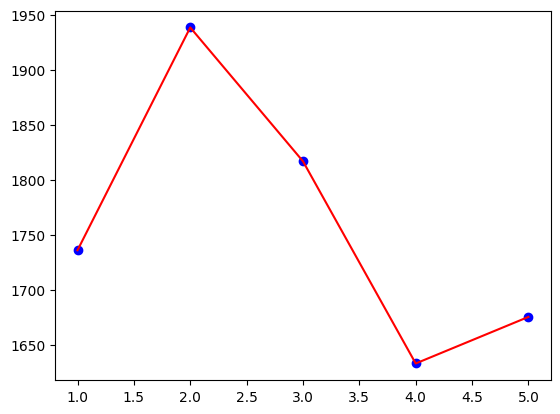

In [86]:
number_degrees = [1,2,3,4,5]
plt_mean_squared_error = []
for degree in number_degrees:

   poly_model_complete = PolynomialFeatures(degree=degree)

   poly_x_train_complete = poly_model_complete.fit_transform(X_train_complete)
   poly_x_test_complete = poly_model_complete.fit_transform(X_test_complete)

   poly_model_complete.fit(poly_x_train_complete, y_train_complete)

   regression_model_complete = LinearRegression()
   regression_model_complete.fit(poly_x_train_complete, y_train_complete)

   y_pred_complete = regression_model_complete.predict(poly_x_test_complete)
  
   plt_mean_squared_error.append(mean_squared_error(y_test_complete, y_pred_complete, squared=False))
  
plt.scatter(number_degrees,plt_mean_squared_error, color="blue")
plt.plot(number_degrees,plt_mean_squared_error, color="red") 

In [87]:
np.min(plt_mean_squared_error)

1633.4981016108911

### Multivariate Polynomial Regression with reduced data

- RMSE: 1607.787357591157

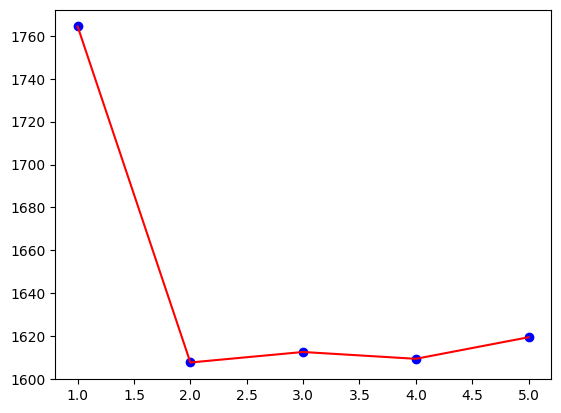

In [88]:
number_degrees = [1,2,3,4,5]
plt_mean_squared_error = []
for degree in number_degrees:

   poly_model_reduced = PolynomialFeatures(degree=degree)
   
   poly_x_train_reduced = poly_model_reduced.fit_transform(X_train_reduced)
   poly_x_test_reduced = poly_model_reduced.fit_transform(X_test_reduced)

   poly_model_reduced.fit(poly_x_train_reduced, y_train_reduced)
  
   regression_model_reduced = LinearRegression()
   regression_model_reduced.fit(poly_x_train_reduced, y_train_reduced)
   y_pred_reduced = regression_model_reduced.predict(poly_x_test_reduced)
  
   plt_mean_squared_error.append(mean_squared_error(y_test_reduced, y_pred_reduced, squared=False))
  
plt.scatter(number_degrees,plt_mean_squared_error, color="blue")
plt.plot(number_degrees,plt_mean_squared_error, color="red") 

In [89]:
np.min(plt_mean_squared_error)

1607.787357591157

# Save model

# Load model

# Get minute forecast

In [22]:
import json

In [23]:
with open('minute_forecast.json') as file:
    forecast = json.load(file)

In [24]:
forecast.keys()

dict_keys(['lat', 'lon', 'timezone', 'timezone_offset', 'current', 'minutely', 'hourly', 'daily'])

In [25]:
unneeded_keys = ['minutely']

In [26]:
for key in unneeded_keys:
    forecast.pop(key, None)

In [27]:
forecast['hourly'][0].keys()

dict_keys(['dt', 'temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'uvi', 'clouds', 'visibility', 'wind_speed', 'wind_deg', 'wind_gust', 'weather', 'pop'])

In [28]:
df_processed.keys()

Index(['dt', 'clouds', 'uvi', 'temp', 'wind_speed', 'wind_deg', 'wind_gust',
       'feels_like', 'pressure', 'dew_point', 'humidity', 'current', 'voltage',
       'power', 'is_day'],
      dtype='object')

In [29]:
processed_forecast = []
keys=['dt', 'clouds', 'uvi', 'temp', 'wind_speed', 'wind_deg', 'wind_gust',
       'feels_like', 'pressure', 'dew_point', 'humidity', 'is_day']
sample_dict = {}
for key in keys:
    sample_dict[key] = None

In [30]:
def is_day(timestamp):
    for day in forecast['daily']:
        day_starttime = day['dt']- 36000
        diff = timestamp - day_starttime
        if diff >= 0 and diff < 86400:
            return 1 if day['sunrise'] < timestamp and day['sunset'] > timestamp else 0

In [31]:
for hour in forecast['hourly']:
    hour['is_day'] = is_day(hour['dt'])
    pop_keys = set(hour.keys()) - set(sample_dict.keys())
    for key in pop_keys:
        hour.pop(key, None)
    d = sample_dict.copy() | hour
    processed_forecast.append(list(d.values()))
    

In [32]:
hours = []

In [33]:
for hour in processed_forecast:
    hours.append(hour[0])

In [40]:
pred_complete = StdS_y.inverse_transform(regressor_complete.predict(StdS_X.transform(processed_forecast)).reshape(-1,1))

/home/raphi/.pyenv/versions/3.11.3/envs/GreenAI_regression/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


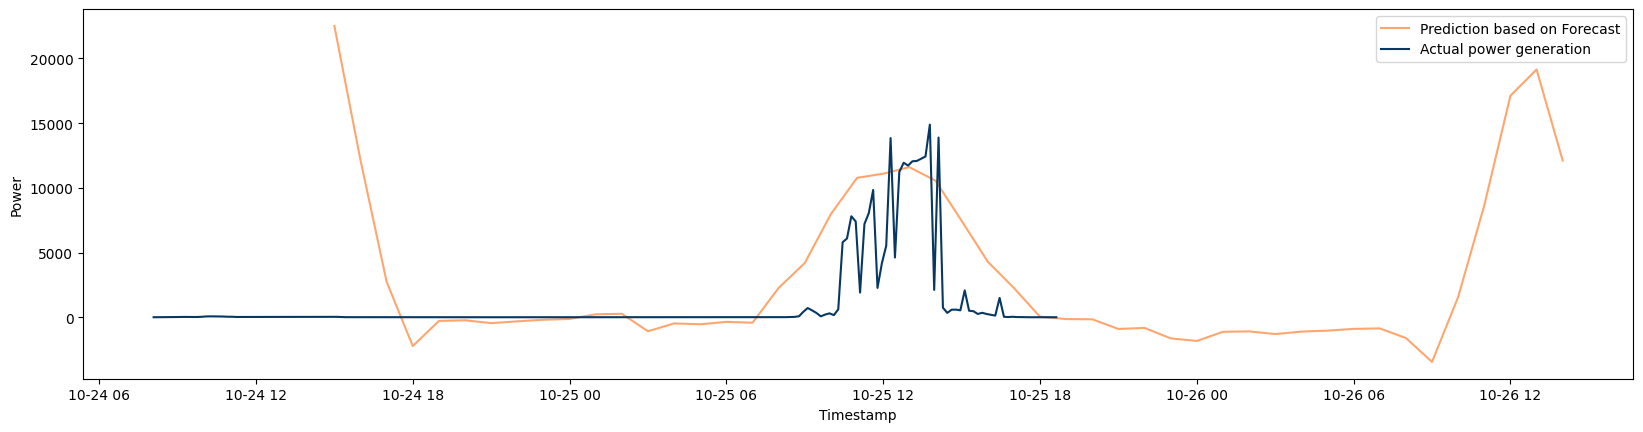

In [85]:
fig, ax = plt.subplots()

ax.plot(hours_datetime, pred_complete, color='#ffa66f', label="Prediction based on Forecast")
ax.plot(test_timestamps_datetime, test_power, color='#073763', label="Actual power generation")
legend = ax.legend(loc='upper right')
# ax.bar(hours, pred_complete)
fig.set_figwidth(20)
plt.ylabel("Power")
plt.xlabel("Timestamp")
# plt.xticks(hours)
plt.show()

In [ ]:
fig, ax = plt.subplots()

ax.plot(hours_datetime, pred_complete, color='#ffa66f', label="Prediction based on Forecast")
ax.plot(test_timestamps_datetime, test_power, color='#073763', label="Actual power generation")
legend = ax.legend(loc='upper right')
# ax.bar(hours, pred_complete)
fig.set_figwidth(20)
plt.ylabel("Power")
plt.xlabel("Timestamp")
# plt.xticks(hours)
plt.show()

In [35]:
df_test = pd.read_csv("2023-10-25_20 03 15_weather_log.csv")

In [36]:
df_test_reduced = df_test[df_test.dt > 1698127200]

In [37]:
test_timestamps = df_test_reduced['dt'].to_numpy()
test_power = df_test_reduced['power'].to_numpy()

In [43]:
hours_datetime = [datetime.fromtimestamp(timestamp) for timestamp in hours]

In [45]:
test_timestamps_datetime = [datetime.fromtimestamp(timestamp) for timestamp in test_timestamps]

In [61]:
pred_complete_cleaned = [0 if power[0] < 0 else power[0] for power in pred_complete.tolist()]

In [68]:
from subset import subset_sum_closest

In [142]:
consumers =[5000,3000,1000,3500,8000,4000]
queue = []
labels = []

In [143]:
for power in pred_complete_cleaned:
    selected_consumers, usage = subset_sum_closest(consumers, int(power))
    queue.append(usage)
    if selected_consumers:
        labels.append(selected_consumers)
    else:
        labels.append(' ')

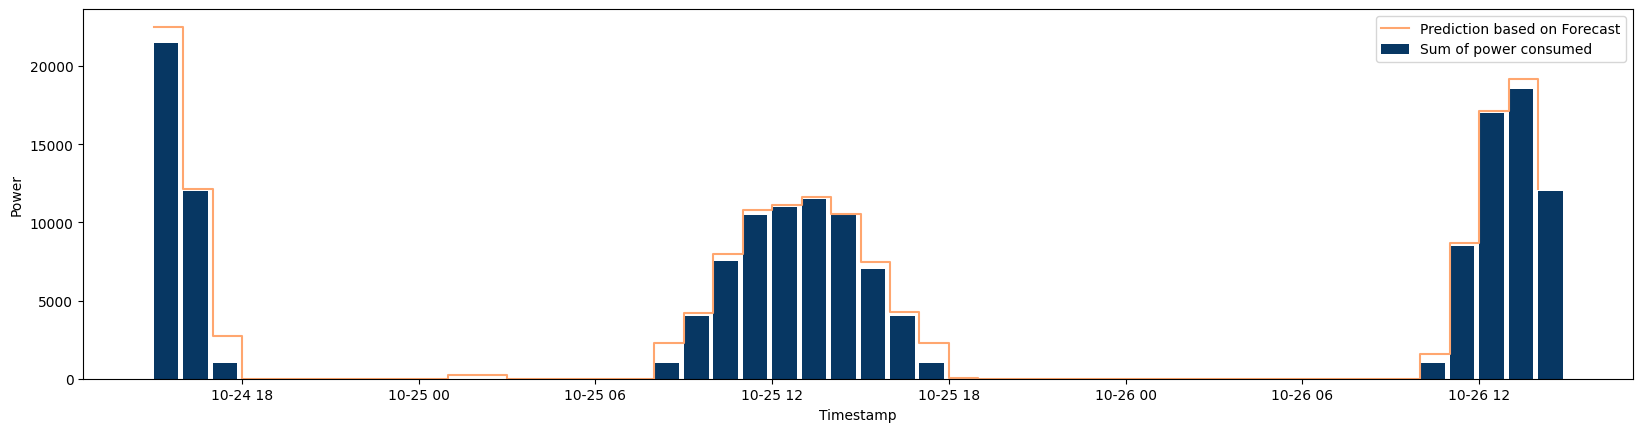

In [149]:
fig, ax = plt.subplots()

ax.step(hours_datetime, pred_complete_cleaned, color='#ffa66f', label="Prediction based on Forecast", where='post')
# ax.plot(test_timestamps_datetime, test_power, color='#073763', label="Actual power generation")
bars = ax.bar(hours_datetime, queue, width=0.035, align='edge', color='#073763', label='Sum of power consumed')
legend = ax.legend(loc='upper right')
# ax.bar_label(bars, labels=labels, label_type='center', rotation=90, color='white')
fig.set_figwidth(20)
plt.ylabel("Power")
plt.xlabel("Timestamp")
# plt.xticks(hours)
plt.show()